# Volatility Scaling

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sqlalchemy import create_engine

In [15]:
raw_data = pd.read_csv('data/vol_data_starkware.csv')

In [16]:
firm_pod_data = raw_data.iloc[:,0:4]

In [17]:
firm_pod_data['date'] = pd.to_datetime(firm_pod_data['date'])
#firm_pod_data['Monthly Returns - Issuer'] = firm_pod_data['Monthly Returns - Issuer'].str.rstrip('%').astype(float) / 100.0
#firm_pod_data['Monthly Returns - Pod'] = firm_pod_data['Monthly Returns - Pod'].str.rstrip('%').astype(float) / 100.0

In [18]:
#firm_pod_data.columns

In [19]:
# firm_pod_data[15:30][['date', 'geometric_avg_return_issuer', 'geometric_avg_return_pod',
#        'vol_scaled_return_pod', 'rolling_std_pod_ann', 'var_scaled_return_pod_2', 'vol_scaled_return_issuer_pod_vol',
#        'vol_issuer','vol_issuer_div_pod_vol']]

firm_pod_data.head()

,date,229016-26 - Starkware,Monthly Returns - Issuer,Monthly Returns - Pod
0,2018-05-31,1.000000,NaN,NaN
1,2018-06-30,1.003428,0.003428,0.003428
2,2018-07-31,1.008563,0.005118,0.005118
3,2018-08-31,1.151799,0.142020,0.142020
4,2018-09-30,1.100387,-0.044636,-0.044636


## John Vol Reproduced

In [20]:
window_size = 12

In [21]:
firm_pod_data['rolling_std_pod'] = firm_pod_data['Monthly Returns - Pod'].rolling(window=window_size).std(ddof=0)
firm_pod_data['geometric_avg_return_issuer'] = firm_pod_data['Monthly Returns - Issuer'].rolling(window=window_size).apply(lambda x: np.prod(1 + x)**(1/len(x)) - 1).abs()
firm_pod_data['geometric_avg_return_pod'] = firm_pod_data['Monthly Returns - Pod'].rolling(window=window_size).apply(lambda x: np.prod(1 + x)**(1/len(x)) - 1).abs()

In [22]:
firm_pod_data['vol_scaled_return_pod'] = firm_pod_data['geometric_avg_return_pod'] / firm_pod_data['rolling_std_pod']
firm_pod_data['rolling_std_pod_ann'] = firm_pod_data['rolling_std_pod'] *np.sqrt(12)
firm_pod_data['var_scaled_return_pod'] = firm_pod_data['vol_scaled_return_pod'] / firm_pod_data['rolling_std_pod_ann']
firm_pod_data['var_scaled_return_pod_2'] = firm_pod_data['geometric_avg_return_pod'].abs() / (np.sqrt(12)* firm_pod_data['rolling_std_pod']**2)
firm_pod_data['vol_scaled_return_issuer_pod_vol'] = firm_pod_data['geometric_avg_return_issuer'].rolling(window=6).mean() / firm_pod_data['rolling_std_pod'].rolling(window=6).mean()
firm_pod_data['vol_issuer'] = firm_pod_data['vol_scaled_return_issuer_pod_vol'].rolling(window=6).mean()  / firm_pod_data['var_scaled_return_pod_2'].rolling(window=6).mean() 
firm_pod_data['vol_issuer_div_pod_vol'] = firm_pod_data['vol_issuer'] / firm_pod_data['rolling_std_pod_ann']

<AxesSubplot:>

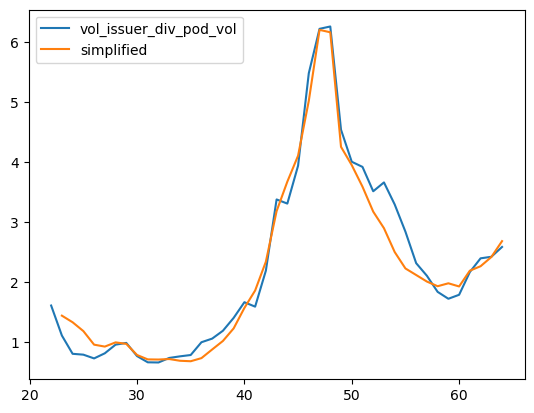

In [23]:
#simplify
firm_pod_data['simplified'] = firm_pod_data['geometric_avg_return_issuer'].abs().rolling(window=12).mean()\
/ firm_pod_data['geometric_avg_return_pod'].abs().rolling(window=6).mean()

firm_pod_data[['vol_issuer_div_pod_vol', 'simplified']].plot()

In [24]:
firm_pod_data.simplified.mean()

2.190389110798615

In [25]:
scaling_factor

2.3624752613468267

In [26]:
scaling_factor = firm_pod_data.vol_issuer.mean() / firm_pod_data.rolling_std_pod_ann.mean()

In [27]:
firm_pod_data['vol_adjusted_pod_return'] = firm_pod_data['Monthly Returns - Pod'] * scaling_factor

In [28]:
df_plot = firm_pod_data[['date', 'Monthly Returns - Issuer', 'vol_adjusted_pod_return']]
df_plot.set_index('date', inplace = True)

<AxesSubplot:title={'center':'John Vol.'}, xlabel='date'>

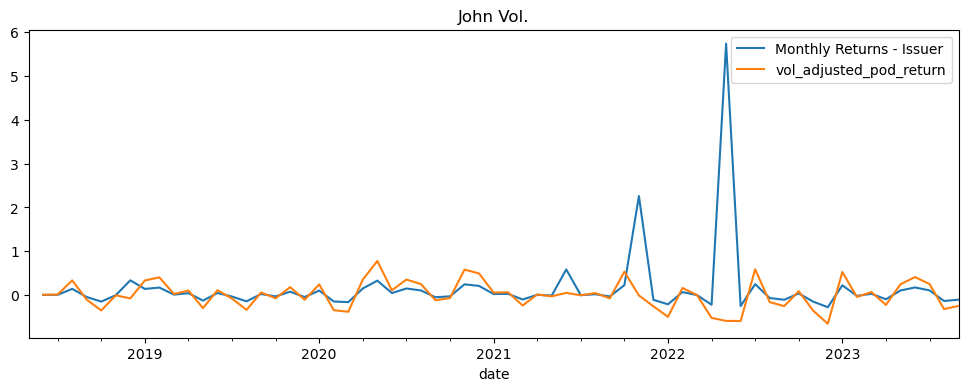

In [29]:
df_plot.plot(figsize = (12,4), title = "John Vol.")

## Adjusted Methodology

In [30]:
clean_pod_data = raw_data.iloc[:,0:4]

In [31]:
clean_pod_data.tail()

,date,229016-26 - Starkware,Monthly Returns - Issuer,Monthly Returns - Pod
60,5/31/23,43.252893,0.104100,0.104100
61,6/30/23,50.772551,0.173853,0.173853
62,7/31/23,56.202362,0.106944,0.106944
63,8/31/23,48.596796,-0.135325,-0.135325
64,9/30/23,43.513988,-0.104591,-0.104591


In [32]:
clean_pod_data.columns

Index(['date', '229016-26 - Starkware', 'Monthly Returns - Issuer',
       'Monthly Returns - Pod'],
      dtype='object')

In [33]:
clean_pod_data['vol_factor'] = clean_pod_data['Monthly Returns - Issuer'].rolling(12).std() / clean_pod_data['Monthly Returns - Pod'].rolling(12).std()  

In [34]:
#(clean_pod_data['Monthly Returns - Pod'] * clean_pod_data.vol_factor).plot()

In [25]:
def rolling_mad(series, window_size):
    """
    Calculate the rolling Median Absolute Deviation (MAD) for a pandas Series.
    
    Parameters:
    - series: pandas Series
    - window_size: int, size of the rolling window
    
    Returns:
    - pandas Series containing the rolling MAD values
    """
    def mad(values):
        median_val = values.median()
        deviations = abs(values - median_val)
        return deviations.median()
    
    return series.rolling(window=window_size).apply(mad)

In [36]:
#clean_pod_data['issuer_returns_capped'] = clean_pod_data['Monthly Returns - Issuer'].clip(-1,1)

In [37]:
clean_pod_data['rolling_MAD_issuer'] = rolling_mad(clean_pod_data['Monthly Returns - Issuer'], 12)
clean_pod_data['rolling_std_issuer'] = clean_pod_data['Monthly Returns - Issuer'].rolling(12).std()

<AxesSubplot:xlabel='date'>

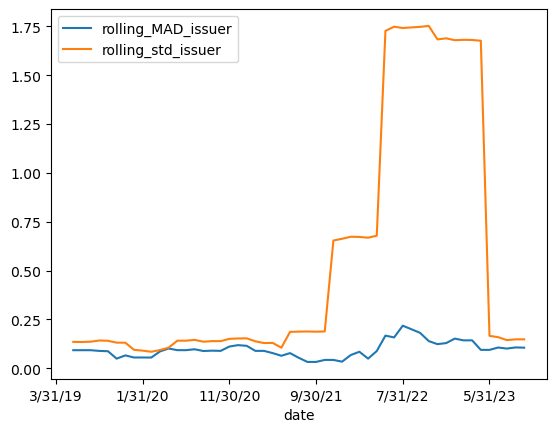

In [38]:
df_quick_plot = clean_pod_data[['date', 'rolling_MAD_issuer', 'rolling_std_issuer']]
df_quick_plot.set_index('date', inplace = True)
df_quick_plot.plot()

In [39]:
clean_pod_data['mad_factor'] = rolling_mad(clean_pod_data['Monthly Returns - Issuer'], 12) / rolling_mad(clean_pod_data['Monthly Returns - Pod'], 12)  

In [40]:
#(clean_pod_data['Monthly Returns - Pod'] * clean_pod_data.mad_factor).plot()

In [41]:
clean_pod_data['mad_adjusted_pod_return'] = clean_pod_data['Monthly Returns - Pod'] * clean_pod_data.mad_factor

In [42]:
df_plot2 = clean_pod_data[['date', 'Monthly Returns - Issuer', 'mad_adjusted_pod_return']].dropna()
df_plot2['date'] = pd.to_datetime(df_plot2['date'])
df_plot2.set_index('date', inplace = True)

In [43]:
df_plot2.corr()

,Monthly Returns - Issuer,mad_adjusted_pod_return
Monthly Returns - Issuer,1.000000,-0.313259
mad_adjusted_pod_return,-0.313259,1.000000


In [44]:
#np.sqrt(mean_squared_error(df_plot2['Monthly Returns - Issuer'].dropna(), df_plot2['mad_adjusted_pod_return'].dropna()))

In [45]:
df_plot2.min()

Monthly Returns - Issuer   -0.276897
mad_adjusted_pod_return    -0.840549
dtype: float64

In [46]:
df_plot2[df_plot2.mad_adjusted_pod_return < -0.7]

,Monthly Returns - Issuer,mad_adjusted_pod_return
date,,
2022-04-30,-0.220813,-0.745632
2022-05-31,5.739664,-0.840549


In [47]:
#df_plot2[df_plot2.index > '2021-12-31']

<AxesSubplot:title={'center':'MAD adjusted returns'}, xlabel='date'>

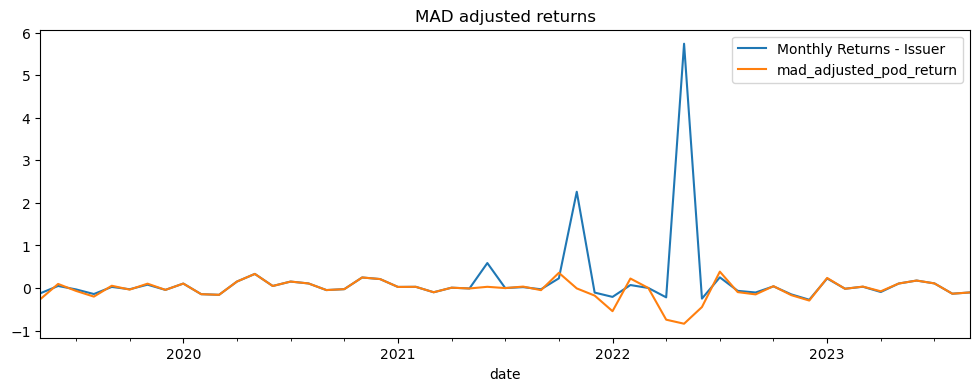

In [48]:
df_plot2.plot(figsize = (12,4), title = "MAD adjusted returns")

In [49]:
df_plot.corr()

,Monthly Returns - Issuer,vol_adjusted_pod_return
Monthly Returns - Issuer,1.000000,-0.066486
vol_adjusted_pod_return,-0.066486,1.000000


<AxesSubplot:title={'center':'John Vol Estimate'}, xlabel='date'>

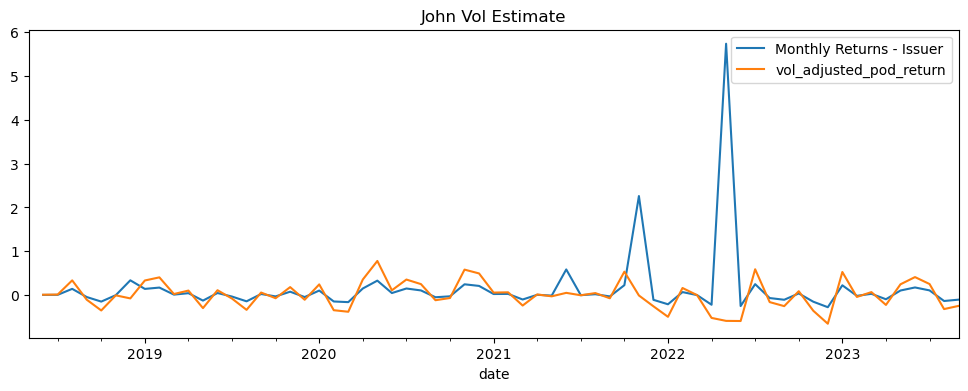

In [50]:
df_plot.plot(figsize = (12,4), title = "John Vol Estimate")

# Pull From Database

In [3]:
# Postgres username, password, and database name
POSTGRES_ADDRESS = 'ec2-107-20-234-141.compute-1.amazonaws.com' 
POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'u6ahibb5jivje6' 
POSTGRES_PASSWORD = 'p9495d4396b8363aced004e566b8727e1aa77ac4d468e898442a6ed92e4195c9c'
POSTGRES_DBNAME = 'd9vfi8hnvbebov' 

In [4]:
# A long string that contains the necessary Postgres login information
postgres_str = ('postgresql+psycopg2://{username}:{password}@{ipaddress}:{port}/{dbname}'\
                .format(username=POSTGRES_USERNAME,\
                        password=POSTGRES_PASSWORD,\
                        ipaddress=POSTGRES_ADDRESS,\
                        port=POSTGRES_PORT,\
                        dbname=POSTGRES_DBNAME))

In [8]:
cnx = create_engine(postgres_str)

In [9]:
company_id_mapping = pd.read_sql_query('''SELECT * FROM reference.company;''', cnx)

In [10]:
pod_pub_mkt_sig = pd.read_sql_query('''SELECT * FROM timeseries.pod_public_market_signal WHERE date_updated = '2023-08-31' AND data_field = 'price' AND data_point = 'mom_return';''', cnx)

In [11]:
private_company_prices = pd.read_csv('data/imputed_price_data_10112023.csv')

In [12]:
fmv_cutoff = 250e6

In [13]:
sectors_to_filter = ['Biotechnology', 'Pharmaceuticals', 'Other Pharmaceuticals and Biotechnology', 'Drug Discovery',\
                    'Enterprise Systems (Healthcare)', 'Drug Delivery', 'Discovery Tools (Healthcare)']

In [14]:
company_id_mapping = company_id_mapping[~company_id_mapping.primary_industry.isin(sectors_to_filter)]

In [15]:
pbid_list = pod_pub_mkt_sig.pbid.unique().tolist()

In [16]:
company_id_mapping = company_id_mapping[company_id_mapping['pbid'].isin(pbid_list)]

In [17]:
pbid_list = company_id_mapping.pbid.unique().tolist()

In [18]:
#cutoff firms below fmv cutoff
priv_prices_trunc = private_company_prices[private_company_prices.final_valuation >= fmv_cutoff].copy()
priv_prices_trunc = priv_prices_trunc[['date', 'pbid', 'implied_imputed_price']].copy()
priv_prices_trunc['date'] = pd.to_datetime(priv_prices_trunc['date'])
priv_prices_trunc = priv_prices_trunc[priv_prices_trunc['pbid'].isin(pbid_list)]
priv_prices_trunc['company_return'] = priv_prices_trunc.sort_values(by = 'date').groupby('pbid')['implied_imputed_price'].pct_change()

priv_prices_trunc.drop_duplicates(inplace = True)

pod_returns_M = pod_pub_mkt_sig[['date', 'pbid', 'value']].copy()
pod_returns_M.rename(columns = {'value': 'pod_return'}, inplace = True)
pod_returns_M['date'] = pd.to_datetime(pod_returns_M['date'])

pod_returns_M.drop_duplicates(inplace = True)

company_name = company_id_mapping[['pbid', 'name']].copy()
company_name.drop_duplicates(inplace = True)

In [26]:
priv_prices_trunc['mom_return'] = priv_prices_trunc.sort_values(by = 'date').groupby('pbid')['implied_imputed_price'].pct_change()

In [27]:
result_frame = priv_prices_trunc.merge(pod_returns_M, on=['date', 'pbid']).merge(company_name, on = 'pbid', how = 'left')

In [28]:
result_frame = result_frame[['date', 'name', 'pbid', 'company_return','pod_return']]

In [29]:
result_frame.head()

,date,name,pbid,company_return,pod_return
0,2019-04-30,Maven (Clinics/Outpatient Services),100024-12,NaN,0.037362
1,2019-05-31,Maven (Clinics/Outpatient Services),100024-12,1.107625,-0.013309
2,2019-06-30,Maven (Clinics/Outpatient Services),100024-12,-0.181767,0.062441
3,2019-07-31,Maven (Clinics/Outpatient Services),100024-12,-0.416945,-0.055313
4,2019-08-31,Maven (Clinics/Outpatient Services),100024-12,-0.123849,-0.036683


In [30]:
roll_window = 12

In [31]:
result_frame['rolling_MAD_issuer'] = result_frame.groupby('name')['company_return'].transform(lambda x: rolling_mad(x, roll_window))
result_frame['rolling_MAD_pod'] = result_frame.groupby('name')['pod_return'].transform(lambda x: rolling_mad(x, roll_window))

In [32]:
result_frame['mad_factor'] = result_frame['rolling_MAD_issuer'] / result_frame['rolling_MAD_pod'] 

In [33]:
result_frame['mad_adjusted_pod_return'] = result_frame.pod_return * result_frame.mad_factor

In [34]:
result_frame[result_frame['name'].str.contains('Apollo', case = False, regex = True)]['name'].unique()

array(['Apollo', 'Apollo Graph'], dtype=object)

In [40]:
result_frame[result_frame.name == 'Stripe']['mad_factor'].mean()

1.2492856783685584

<AxesSubplot:title={'center':'MAD adjusted returns'}, xlabel='date'>

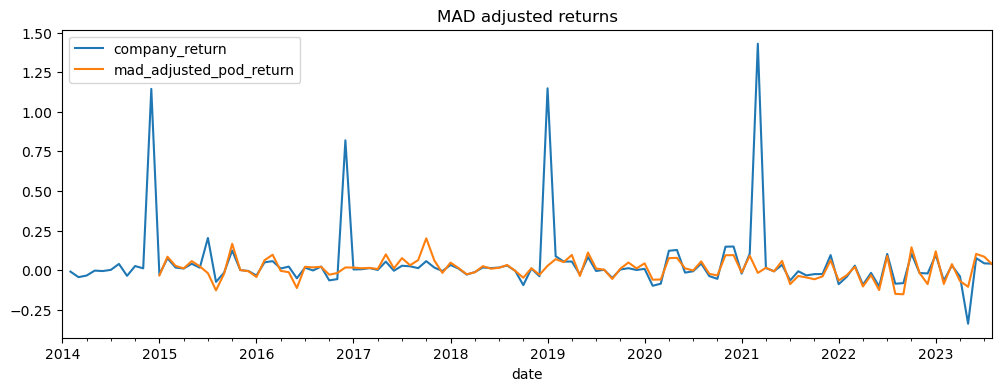

In [35]:
#plot_frame = result_frame[result_frame.pbid == '100151-92'][['date','company_return', 'mad_adjusted_pod_return']]
plot_frame = result_frame[result_frame.name == 'Stripe'][['date','company_return', 'mad_adjusted_pod_return']]

plot_frame.set_index('date', inplace = True)
plot_frame.plot(figsize = (12,4), title = "MAD adjusted returns")

In [36]:
plot_frame.dropna().mean()

company_return             0.037951
mad_adjusted_pod_return    0.008534
dtype: float64

In [37]:
plot_frame.dropna().std()

company_return             0.205576
mad_adjusted_pod_return    0.065461
dtype: float64